In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
%matplotlib inline

In [3]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h1>Evaluating Data</h1>

In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
messages['length'] = messages['message'].apply(len)

In [8]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<AxesSubplot:ylabel='Frequency'>

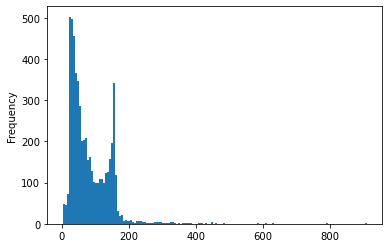

In [9]:
messages['length'].plot.hist(bins = 150)

In [10]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [11]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

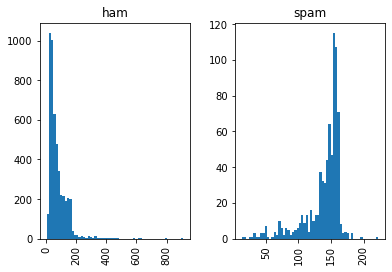

In [12]:
messages.hist(column='length',by='label',bins=60)

In [13]:
# Text pre processing: tokenize messages
import string
from nltk.corpus import stopwords
def text_process(mess):
#     removing punctuation by list comprehension
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
# removing stopwords and returning the messages
    return [word for word in nopunc.split() if word not in stopwords.words('english')]

In [14]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, I, dont, think, goes, usf, lives, around...
Name: message, dtype: object

In [15]:
# vectorization: bag-of-words model 
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [17]:
print(len(bow_transformer.vocabulary_))

11617


In [18]:
# ex
message = messages['message'][23]
bow = bow_transformer.transform([message])
print(bow)
print(bow.shape)
bow_transformer.get_feature_names_out()[6762]

  (0, 543)	1
  (0, 1032)	1
  (0, 1104)	1
  (0, 4221)	1
  (0, 4821)	1
  (0, 6762)	2
  (0, 7056)	1
  (0, 8080)	2
  (0, 8139)	2
  (0, 10073)	1
  (0, 10309)	1
  (0, 10969)	1
(1, 11617)


'finish'

In [19]:
messages_bow = bow_transformer.transform(messages['message']) 

In [20]:
print('shape of Sparse Matrix',messages_bow.shape)

shape of Sparse Matrix (5572, 11617)


In [21]:
messages_bow.nnz

56024

In [22]:
# normalize
from sklearn.feature_extraction.text import TfidfTransformer

In [23]:
tfidf_tansformer = TfidfTransformer().fit(messages_bow)

In [24]:
# ex
tfidf = tfidf_tansformer.transform(bow)
print(tfidf)

  (0, 10969)	0.15265259685749885
  (0, 10309)	0.30074794779046454
  (0, 10073)	0.25710969039698384
  (0, 8139)	0.44736561521936674
  (0, 8080)	0.3493515909102149
  (0, 7056)	0.156944962310958
  (0, 6762)	0.4533715849534418
  (0, 4821)	0.19401467906413292
  (0, 4221)	0.14880129197113393
  (0, 1104)	0.2747429492796578
  (0, 1032)	0.30074794779046454
  (0, 543)	0.20509969337537037


In [25]:
tfidf_tansformer.idf_[bow_transformer.vocabulary_['university']]

8.527076498901426

In [26]:
messages_tfidf = tfidf_tansformer.transform(messages_bow)

In [27]:
# classification: naive bayes
from sklearn.naive_bayes import MultinomialNB

In [28]:
spam_detect_model = MultinomialNB().fit(messages_tfidf,messages['label'])

In [29]:
# ex
spam_detect_model.predict(tfidf)[0]

'ham'

In [30]:
all_pred = spam_detect_model.predict(messages_tfidf)
all_pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [31]:
# train_test_split
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(messages['message'],messages['label'],test_size=0.3)

In [32]:
# pipeline
from sklearn.pipeline import Pipeline

In [33]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [34]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f9366772670>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [35]:
predictions = pipeline.predict(msg_test)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1430
        spam       1.00      0.69      0.82       242

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672

